In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier,export_text
import seaborn as sns
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.feature_selection import SelectPercentile
import pickle
from treeinterpreter import treeinterpreter as ti
from sklearn.metrics import accuracy_score, classification_report

In [2]:
# loading and converting anatomical data
all_anatomy_LR1=pd.read_excel('.\Lippa_data.xlsx','Anatomy', index_col='ID')
all_anatomy_LR1=all_anatomy_LR1.drop(['Timestamp', 'Horse', 'Temperature'], axis=1)
all_anatomy_LR2=pd.read_excel('.\Lippa_data_25ijs.xlsx','Anatomy', index_col='ID')
all_anatomy_LR2=all_anatomy_LR2.drop(['Horse'], axis=1)
all_anatomy_LR=all_anatomy_LR1.append(all_anatomy_LR2).sort_index()
all_anatomy_LR['Sex']=all_anatomy_LR['Sex'].replace(['M','G'],['1','0'])

d:\Users\alexatopal\AppData\Local\Temp\2\ipykernel_26096\4216163439.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_anatomy_LR=all_anatomy_LR1.append(all_anatomy_LR2).sort_index()


In [3]:
# loading and converting kinematic data
kinematics1=pd.read_excel('.\Lippa_experiments.xlsx','Kinematics_all', index_col='ID')
kinematics2=pd.read_excel('.\Lippa_experiments.xlsx','Kinematics_all_new25', index_col='ID')
kinematics_all=kinematics1.append(kinematics2).sort_index()

d:\Users\alexatopal\AppData\Local\Temp\2\ipykernel_26096\3685161432.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  kinematics_all=kinematics1.append(kinematics2).sort_index()


In [4]:
# loading and converting housing data
housing1=pd.read_excel('.\Lippa_data.xlsx','Housing and work', index_col='ID')
housing1=housing1.drop(['Horse', 'Timestamp', 'School horse', 'Housing', 'Equine activities', 'Pasture', 'Number of caretakers', 'Box openess', 'Injury history' ], axis=1)
housing1['Type of work']='no'
housing1['Type of work']=housing1['Type of work'].where((housing1['Type of work']=='no')&(housing1['Work']==1), 'riding')
housing2=pd.read_excel('.\Lippa_data_25ijs.xlsx','Housing and work', index_col='ID')
housing2=housing2.drop(['Horse'], axis=1)
housing2['Work']=housing2['Work'].replace(['yes','no'],[2,1])
housing=housing1.append(housing2).sort_index()
type_of_work=housing['Type of work'].unique()
housing['Type of work']=housing['Type of work'].replace(list(type_of_work), [0,1,2,3]) #no=0, riding=1,in training=2,show=3

d:\Users\alexatopal\AppData\Local\Temp\2\ipykernel_26096\3200758263.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  housing=housing1.append(housing2).sort_index()


In [5]:
# loading and converting digital data
digital_measurment_of_head1=pd.read_excel('.\Additional data 24 horses.xlsx','Head anatomy', index_col='ID')
digital_measurment_of_head1=digital_measurment_of_head1.drop(['Horse'], axis=1)
digital_measurment_of_head2=pd.read_excel('.\Lippa_data_25ijs.xlsx','Additional anatomy', index_col='ID')
digital_measurment_of_head2=digital_measurment_of_head2.drop(['Horse'], axis=1)
digital_measurment_of_head=digital_measurment_of_head1.append(digital_measurment_of_head2).sort_index()

d:\Users\alexatopal\AppData\Local\Temp\2\ipykernel_26096\668016361.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  digital_measurment_of_head=digital_measurment_of_head1.append(digital_measurment_of_head2).sort_index()


In [6]:
# loading and converting whorls data
whorls_of_head1=pd.read_excel('.\Additional data 24 horses.xlsx','Whorls',index_col='ID' ) 
whorls_of_head1=whorls_of_head1.drop(['Horse', 'Number of whorls', 'Whorl2_Rotation', 'Whorl2_Height', 'Whorl2_Lateral location'], axis=1)
whorls_of_head2=pd.read_excel('.\Lippa_data_25ijs.xlsx','Whorls',index_col='ID' ) 
whorls_of_head2=whorls_of_head2.drop(['Horse', 'Number of whorls', 'Whorl2_Rotation', 'Whorl2_Height', 'Whorl2_Lateral location'], axis=1)
whorls_of_head=whorls_of_head1.append(whorls_of_head2).sort_index()

d:\Users\alexatopal\AppData\Local\Temp\2\ipykernel_26096\3084490103.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  whorls_of_head=whorls_of_head1.append(whorls_of_head2).sort_index()


In [7]:
# loading transformed fear data
fear_max_sum=pd.read_excel('.\Lippa_experiments.xlsx','Fear_max_sum49', index_col='ID')
fear_max_sum=fear_max_sum.sort_index()

Text(0, 0.5, 'Number of horses')

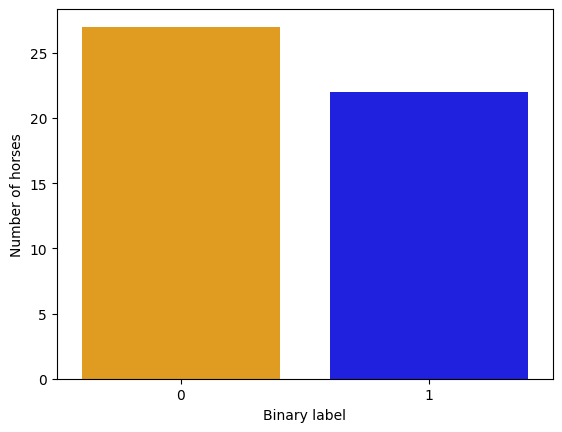

In [8]:
# target features = maximum from sum of repetition divided to two classes.
y=fear_max_sum['binary'] 
tt=fear_max_sum['binary'].value_counts()
plt.figure()
sns.barplot(x=tt.index, y=tt, palette=['orange', 'blue']);
plt.xlabel("Binary label") 
plt.ylabel('Number of horses')

In [9]:
y=y.sort_index()
y.value_counts()


0    27
1    22
Name: binary, dtype: int64

In [10]:
X_initial=pd.concat([all_anatomy_LR, kinematics_all, housing, digital_measurment_of_head, whorls_of_head], axis=1)

#remove features that correlate with each other 

empty_list=[]
# LEFT+front measurements
corr_list_left=["FH10L", "FH11L", "FH12L", "FH13L", "FH14L", "FH16L", "FH18L", "FH19L", "FB08", "FB10L", "FB11L", "FB12L", "FB13L", \
            "FB15L", "FB16L", "FB18L", "FB19L", "FB20L", "FB21L", "FB22L", "FB23L", "FB24L", "FB25L", "FB26L", "FB27L", "FB28L",\
            "FB29L", "FB31L", "FB32L", "FB34L", "FB35L", "FB36L", "FB37L", "FB38", "FB39", "Walk_DV power", "Trot_Stride lengh",\
            "Work", "HMPF1", "HMPF2", "HMPF3", "HMPF4", "HMPF6", "HMPF22", "HMPF23",  "HMPF25", "HMPF27", "HMPF31",\
            "HMPF34", "HMPF35", "HMPF39", "HMPF37", "HMPF41", "HMPF43", "HMPF45", "HMPF47", "HMPL2", "HMPL11", "HMPL12","HMPL15"]

# RIGHT+front measurements
corr_list_right=["FH10R","FH11R","FH12R","FH13R","FH14R","FH16R","FH18R","FH19R","FB09","FB10R","FB11R","FB12R","FB12R","FB13R","FB14R",\
            "FB15R","FB16R","FB18R","FB19R","FB20R","FB21R","FB22R","FB23R","FB24R","FB25R","FB26R","FB27R","FB28R","FB29R","FB31R",\
            "FB32R","FB34R","FB35R","FB36R","FB37R","FB39","FB40","Walk_Speed","Trot_Speed","Type of work","HMPF2","HMPF3","HMPF5","HMPF7",\
            "HMPF20","HMPF21","HMPF24","HMPF26","HMPF30","HMPF32","HMPF33","HMPF36","HMPF38","HMPF40","HMPF42","HMPF44","HMPF46","HMPF69",\
            "HMPR2","HMPR11","HMPR12","HMPR15"]

# LEFT + additianal right + front measurements
corr_list_left_add=["FH10L", "FH11L", "FH12L", "FH13L", "FH14L", "FH16L", "FH18L", "FH19L", "FB08", "FB10L", "FB11L", "FB12L", "FB13L", \
            "FB15L", "FB16L", "FB18L", "FB19L", "FB20L", "FB21L", "FB22L", "FB23L", "FB24L", "FB25L", "FB26L", "FB27L", "FB28L",\
            "FB29L", "FB31L", "FB32L", "FB34L", "FB35L", "FB36L", "FB37L", "FB38", "FB39", "Walk_DV power", "Trot_Stride lengh",\
            "Work", "HMPF1", "HMPF2", "HMPF3", "HMPF4", "HMPF6", "HMPF22", "HMPF23", "HMPF45", "HMPF25", "HMPF27", "HMPF31",\
            "HMPF34", "HMPF35", "HMPF39", "HMPF37", "HMPF41", "HMPF43", "HMPF45", "HMPF47", "HMPL2", "HMPL11", "HMPL12","HMPL15",\
            "HMPF30", "HMPF32", "HMPF69", "HMPR2", "HMPR11", "HMPR12","HMPR15"] 

# # RIGHT + additianal left + front measurements
corr_list_right_add=["FH10R","FH11R","FH12R","FH13R","FH14R","FH16R","FH18R","FH19R","FB09","FB10R","FB11R","FB12R","FB12R","FB13R","FB14R",\
            "FB15R","FB16R","FB18R","FB19R","FB20R","FB21R","FB22R","FB23R","FB24R","FB25R","FB26R","FB27R","FB28R","FB29R","FB31R",\
            "FB32R","FB34R","FB35R","FB36R","FB37R","FB39","FB40","Walk_Speed","Trot_Speed","Type of work","HMPF2","HMPF3","HMPF5","HMPF7",\
            "HMPF20","HMPF21","HMPF24","HMPF26","HMPF30","HMPF32","HMPF33","HMPF36","HMPF38","HMPF40","HMPF42","HMPF44","HMPF46","HMPF71",\
            "HMPR2","HMPR11","HMPR12","HMPR15", "FB12L", "HMPF23", "HMPF35", "HMPF39", "HMPF45", "HMPL12", "HMPL13", "HMPL17"]    


#left column of corr matrix
corr_list_feature1=["FH10L","FH11L","FH12L","FH13L","FH14L","FH16L","FH18L","FH19L","FB08","FB10L","FB11L","FB12L","FB13L","FB15L","FB16L","FB18L",\
           "FB19L","FB20L","FB21L","FB22L","FB23L","FB24L","FB25L","FB26L","FB27L","FB28L","FB29L","FB31L","FB32L","FB34L","FB35L","FB36L",\
           "FB37L","FB38","FB39","Walk_DV power","Trot_Stride lengh","Work","HMPF1","HMPF2","HMPF3","HMPF4","HMPF6","HMPF20","HMPF21","HMPF22",\
           "HMPF24", "HMPF26", "HMPF30", "HMPF32", "HMPF33", "HMPF34", "HMPF36", "HMPF38", "HMPF40", "HMPF42", "HMPF44", "HMPF46", "HMPF69",\
           "HMPL2", "HMPL11", "HMPL12", "HMPL15", "HMPR2", "HMPR11", "HMPR12", "HMPR15"]

#right column of corr matrix
corr_list_feature2=["FH10R","FH11R","FH12R","FH13R","FH14R","FH16R","FH18R","FH19R","FB09","FB10R","FB11R","FB12L","FB12R","FB13R","FB14R","FB15R",\
        "FB16R","FB18R","FB19R","FB20R","FB21R","FB22R","FB23R","FB24R","FB25R","FB26R","FB27R","FB28R","FB29R","FB31R","FB32R","FB34R","FB35R",\
        "FB36R","FB37R","FB39","FB40","Walk_Speed","Trot_Speed","Type of work","HMPF2","HMPF3","HMPF5","HMPF7","HMPF22","HMPF23","HMPF45",\
        "HMPF25", "HMPF27","HMPF31", "HMPF32","HMPF33", "HMPF34","HMPF35","HMPF38","HMPF39","HMPF37","HMPF41","HMPF43","HMPF45","HMPF47",\
        "HMPF71","HMPL13","HMPL12","HMPL17","HMPR11","HMPR12","HMPR13","HMPR17"]

unique_features = [
    "Age",
    "Trot_Speed",
    "HMPF38",
    "FB35R",
    "HMPF16",
    "FB16L",
    "FH10R",
    "FB15L",
    "HMPL5",
    "HMPR1",
    "HMPF73",
]
best_of_the_best=['Age','Trot_Speed','HMPL5','FB16L','FB35R','FH10R','HMPR1','HMPF38']

# use of important features identified by DT models with an accuracy >0.8 determined at the first stage of the study

# 1.step : removing "unique_features" list
# 2.step : removing "best_of_the_best" list

remove_bad_features = [item for item in X_initial.columns if item not in best_of_the_best ]


In [11]:
X_initial=X_initial.sort_index()


In [ ]:
rs_list=list(range(1, 15000))
# 1 stage:             
full_corr_list=[empty_list, corr_list_left, corr_list_right, corr_list_left_add, corr_list_right_add, corr_list_feature1, corr_list_feature2]
# 2 stage
# full_corr_list=[remove_bad_features]

def split_by_hand(Features,goal,number):
    y_test=goal[[number]] #chose a value from y
    X_test=Features.iloc[[number]] #chose a value from X
    y_train=np.delete(np.array(goal),(number)) #remove test_instance from the set
    X_train=Features.drop(Features.index[number]) #remove test_instance from the set
    return X_train, X_test, y_train, y_test

max_acc=0
number_of_horses=len(X_initial)

#loop through different lists of features
for corr_list in full_corr_list:
    X=X_initial.drop(corr_list, axis=1)
    print(len(X.columns))
    max_acc=0
    
    #loop by parameters random_state
    for rs in rs_list:
        accuracy_list=[]
        prediction=[]
        selection_features=pd.DataFrame()
        
        #LOO CV loop
        for test_instance in range(number_of_horses):

            X_train, X_test, y_train, y_test=split_by_hand(X,y,test_instance)          
                
            DT_model=tree.DecisionTreeClassifier(criterion='gini', random_state=rs, max_features='sqrt') 
            
            DT_model.fit(X_train,y_train) 
        
            y_predict=DT_model.predict(X_test)  
        
            prediction.append([y_test[0], y_predict[0]])
            
            if (y_predict[0]==y_test[0]):
                accuracy_list.append(1)
            
            feats=pd.DataFrame(index=X.columns, data=DT_model.feature_importances_, columns=['Important'])
            selection_features=pd.concat([selection_features, feats])
        
        if sum(accuracy_list)/number_of_horses>max_acc:
            max_acc=sum(accuracy_list)/number_of_horses
            random_st=rs
        print('Random_state=', rs,'set=', len(X.columns), "Accuracy=", sum(accuracy_list)/number_of_horses, file=open('output_DT49.txt', 'a')) 
    print('Random_state=', random_st,'set=', len(X.columns), "Accuracy=",  max_acc, file=open('output_DT49.txt', 'a')) 

In [ ]:
# accuracy for the defined best random_state parameter
print("Accuracy=", max_acc, 'Random state=', random_st)

Accuracy= 0.9795918367346939 Random state= 5005


<Axes: >

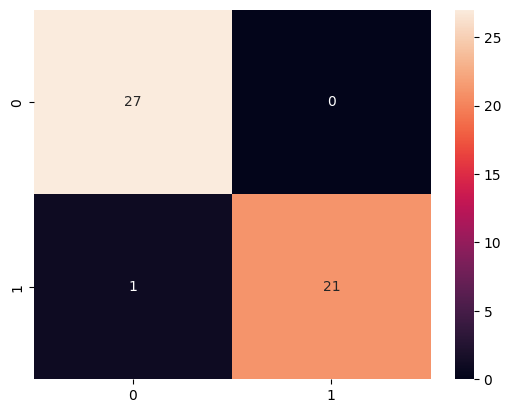

In [ ]:
# confusion_matrix for the defined best random_state parameter
prediction=np.array(prediction)
sns.heatmap(confusion_matrix(prediction[:,0], prediction[:,1]), annot=True)

In [ ]:
# precision and recall for the defined best random_state parameter
compare_matrix=confusion_matrix(prediction[:,0], prediction[:,1])
print(compare_matrix)                                        
precision=compare_matrix[1][1]/(compare_matrix[1][1]+compare_matrix[0][1])
print('Precision=', precision)
recall=compare_matrix[1][1]/(compare_matrix[1][1]+compare_matrix[1][0])
print('Recall=', recall)

[[27  0]
 [ 1 21]]
Precision= 1.0
Recall= 0.9545454545454546


In [ ]:
selection_features[selection_features['Important']!=0]

,Important
Age,0.256684
FB16L,0.197802
FB35R,0.120596
Trot_Speed,0.207335
HMPL5,0.217582
...,...
Age,0.204545
FB16L,0.197802
FB35R,0.127448
Trot_Speed,0.252622


Age           49
FB16L         49
FB35R         49
HMPL5         49
Trot_Speed    49
dtype: int64


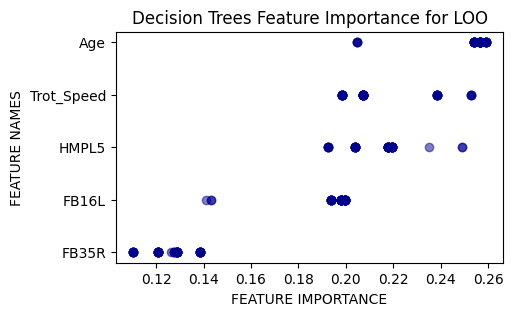

In [ ]:

forplot=selection_features[selection_features['Important']!=0].sort_values(['Important'], axis=False)

sf_list=list(forplot.index)
tt=[i for i in sf_list if sf_list.count(i)<0]
unique=list(set(tt))
for i in unique:
    forplot=forplot.drop(i, axis=0)
print(forplot.value_counts(forplot.index))
plt.figure(figsize=(5,3))
plt.scatter(x=forplot['Important'], y=forplot.index, color='darkblue', alpha=0.5)
plt.title('Decision Trees ' + 'Feature Importance for LOO')
plt.xlabel('FEATURE IMPORTANCE')
plt.ylabel('FEATURE NAMES');

In [ ]:

best_of_the_best=['Age','Trot_Speed','HMPL5','FB16L','FB35R','FH10R','HMPR1','HMPF38']
#use important features were indiacted from DT models with accuracy >0.9
remove_bad_features = [item for item in X_initial.columns if item not in best_of_the_best ]

In [ ]:
# Modeling on the FULL dataset
X=X_initial.drop(remove_bad_features, axis=1)
DTall_model=DecisionTreeClassifier(criterion='gini',  max_features='sqrt', random_state=5005) #use the best random_state

DTall_model.fit(X,y)
pickle.dump(DTall_model, open("DT_model49.pkl", "wb"))

feats_=pd.DataFrame(index=X.columns, data=DTall_model.feature_importances_, columns=['Important'])

entities49=list(X.index)


In [ ]:
feats_[feats_['Important']>0].sort_values('Important', ascending=False)

,Important
Age,0.252327
Trot_Speed,0.214055
HMPL5,0.213889
FB16L,0.194444
FB35R,0.125284


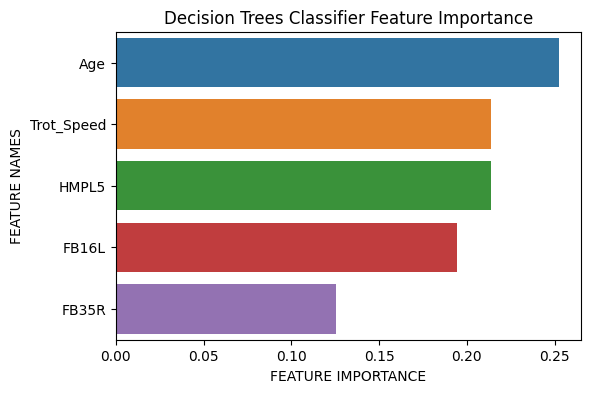

In [ ]:
feats_for_plot=feats_[feats_['Important']>0].sort_values('Important', ascending=False)
plt.figure(figsize=(6,4))
#Plot Searborn bar chart
sns.barplot(x=feats_for_plot['Important'], y=feats_for_plot.index)
#Add chart labels
plt.title('Decision Trees Classifier ' + 'Feature Importance')
plt.xlabel('FEATURE IMPORTANCE')
plt.ylabel('FEATURE NAMES');

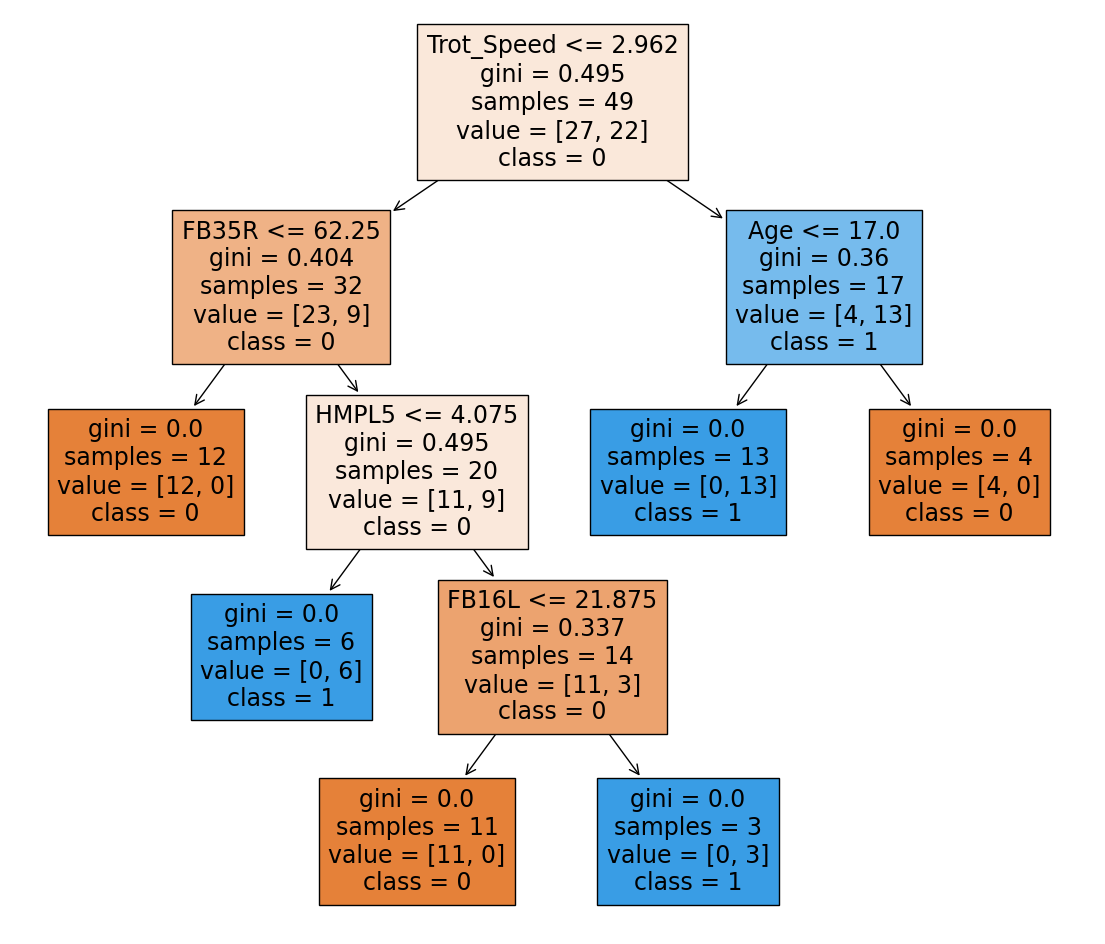

In [ ]:
fig = plt.figure(figsize=(14,12))
_ = tree.plot_tree(DTall_model, feature_names=feats_.index, class_names='01', filled=True)

In [ ]:
tree_text = export_text(DTall_model, feature_names=list(X.columns))
print(tree_text)

|--- Trot_Speed <= 2.96
|   |--- FB35R <= 62.25
|   |   |--- class: 0
|   |--- FB35R >  62.25
|   |   |--- HMPL5 <= 4.08
|   |   |   |--- class: 1
|   |   |--- HMPL5 >  4.08
|   |   |   |--- FB16L <= 21.88
|   |   |   |   |--- class: 0
|   |   |   |--- FB16L >  21.88
|   |   |   |   |--- class: 1
|--- Trot_Speed >  2.96
|   |--- Age <= 17.00
|   |   |--- class: 1
|   |--- Age >  17.00
|   |   |--- class: 0

